Click the link to do the tutorial in Colab:

<a href="https://colab.research.google.com/github/akhti/ammi-2019-ConvNets/blob/master/convnet_tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Standard imports and utiliy functions:

In [0]:
import random

import PIL
import imageio
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
from torchvision import datasets, transforms
from IPython import display

%matplotlib inline

def display_thumb(img):
  display.display(transforms.Resize(128)(img))
  
  
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
if device != 'cuda':
  print('WARNING! No cuda found, the executions may be slow')
  print('If you are using colab, switch to GPU runtime.')

Load MNIST and define train/test functions as before.

In [3]:
# Load the training and test dataset.
mnist_train = datasets.MNIST('/tmp/mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('/tmp/mnist', train=False, download=True, transform=transforms.ToTensor())

# Size of the batches the data loader will produce.
batch_size = 64

# This creates the dataloaders.
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

0it [00:00, ?it/s]

100%|█████████▉| 9879552/9912422 [00:15<00:00, 682298.88it/s]

Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz



0it [00:00, ?it/s]


 57%|█████▋    | 16384/28881 [00:00<00:00, 85085.40it/s]
32768it [00:00, 56074.94it/s]                           
0it [00:00, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz



 95%|█████████▍| 1564672/1648877 [00:03<00:00, 546046.74it/s]

0it [00:00, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz




  0%|          | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 21459.08it/s]            

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model."""  
    # Make sure model is in training mode.
    model.train()
    # Move model to the device.
    model.to(device)
    
    # Exponential moving average of the loss.
    ema_loss = None
    
    # Loop over epochs.
    for epoch in range(num_epochs):    
      # Loop over data.
      for batch_idx, (data, target) in enumerate(data_loader):
          # Forward pass.
          output = model(data.to(device))
          loss = criterion(output.to(device), target.to(device))
          
          # Backward pass.
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          if ema_loss is None:
            ema_loss = loss.item()
          else:
            ema_loss += (loss.item() - ema_loss) * 0.01 
          
      # Print out progress the end of epoch.
      print('Train Epoch: {} \tLoss: {:.6f}'.format(
            epoch, ema_loss),
      )
              
              
def test(model, data_loader):
    """Measures the accuracy of a model on a data set.""" 
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0

    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():   
        # Loop over test data.
        for data, target in data_loader:
          
            # Forward pass.
            output = model(data.to(device))
            
            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)
            
            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = 100. * correct / len(data_loader.dataset)
    #print ('te Accuracy is',percent, '%' )
    print(f'Accuracy: {correct}/{len(data_loader.dataset)} ({percent:.0f}%)')
    return percent
   

## Convolutions and images
The inputs and outputs of convolutional layers are 3D tensor. The number of the channels in the output tensor is defined explicitly with `out_channels` parameter. At the same time, the spatial dimensions of the ouput image (width and height) depend on the spacial dimensions of the input image, kernel_size, padding, and striding. In order to build efficient convolutional networks, it's important to understand what are the sizes after afterh each convolutional layer.

In this exersise you will derive the dependency between input and output sizes. For the sake of simplicity we assume that the input tensor is _square_, i.e., width = height = image_size.

If your code is correct, you should see 'OK'.

In [5]:
def compute_convnet_output_size(image_size, kernel_size, padding, stride):
    
  ###########################################################################
  # TODO: Compute the size of the image after a conv layer.                 #
  # Put your code between START_GRADING and END_GRADING.                    #
  ###########################################################################
  # ~~START_GRADING~~
    
    output_size= int((image_size - kernel_size + 2 * padding)/stride )+ 1
  # ~~END_GRADING~~  
    return output_size


# Compare the size of the output of nn.Conv2d with compute_convnet_output_size.
for image_size in range(5, 21, 1):
  # Shape: batch x channels x height x width.
  input_tensor = torch.zeros((1, 1, image_size, image_size))
  for kernel_size in 2, 3, 5, 7:
    for padding in 0, 5:
      for stride in 1, 2, 3, 4:
        if kernel_size >= image_size:
          continue
        output_tensor = nn.Conv2d(1, 1, kernel_size, stride, padding)(input_tensor)
        output_size = output_tensor.size(2)
        predicted_output_size = compute_convnet_output_size(
            image_size, kernel_size, padding, stride)
        assert output_size == predicted_output_size, (
            f'ERROR: the real size is {output_size},'
            f' but got {predicted_output_size}.'
            f'\nimage_size={image_size}'
            f' kernel_size={kernel_size}'
            f' padding={padding}'
            f' stride={stride}'
        )

print('OK')
        

OK


## BatchNorm


Batch normalization is tenchique that allows to make training more stable fast [1].

Below we define a convolutional network with 3 layers. Before each ReLU layer we insert a BatchNorm2d layer if `use_batch_norm` is `True`. This improves the convergence as guarantees as values have the same variance asn zero-means. As a result on average exactly half of the values will be nulled by ReLU.

[1] Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." arXiv preprint arXiv:1502.03167 (2015).

**Task**. Go ahead and add batch normalization layer.

In [0]:
class ConvolutionalNetworkWithBN(nn.Module):
  """Convolutional network that optional batch normalization."""
  
  def __init__(self, use_batch_norm=False):
      super().__init__()
      num_channels = 8
      self.use_batch_norm = use_batch_norm
      # We define all our layers in a single Sequential. If use_batch_norm is 
      # True, we'd like maybe_batch_norm_layer to produce a batchnorm layer.
      self.conv = nn.Sequential(
          # 1x28x28 -> 8x24x24.
          nn.Conv2d(1, num_channels, kernel_size=5),
          # 8x24x24 -> 8x12x12.
          nn.MaxPool2d(2),
          self.maybe_batch_norm_layer(num_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),          
          self.maybe_batch_norm_layer(num_channels),            
          nn.ReLU(inplace=True),
          # 8x12x12 -> 8x8x8.
          nn.Conv2d(num_channels, num_channels, kernel_size=5),
          # 8x8x8 -> 8x4x4.
          nn.MaxPool2d(2),
          self.maybe_batch_norm_layer(num_channels),
          nn.ReLU(inplace=True),
      )
      self.linear = nn.Linear(num_channels * 4 ** 2, 10)  
      
  def maybe_batch_norm_layer(self, num_channels):
      if self.use_batch_norm:
          ###########################################################################
          # TODO: Add batch norm layer                                              #
          # Put your code between START_GRADING and END_GRADING.                    #
          ###########################################################################
          # ~~START_GRADING~~
          BATCH_NORM2D_LAYER= nn.BatchNorm2d(num_channels)
          return BATCH_NORM2D_LAYER
          # ~~END_GRADING~~
      else:
          # This layer will copy its input to the output.
          
          return nn.Sequential()
      
  def forward(self, x):#
      x = self.conv(x)  
      x = self.linear(x.view(x.size(0), -1))
      return x

To see how batch normalization improves stability, let's try to train the neural network with different learning rates and check the accuracies.

In [7]:
for lr in 0.3, 0.1, 0.03, 0.01, 0.003:
  conv_model = ConvolutionalNetworkWithBN()
  optimizer = torch.optim.SGD(conv_model.parameters(), lr=lr)
  train(conv_model, nn.CrossEntropyLoss(), train_loader, optimizer, num_epochs=1)
  accuracy = test(conv_model, test_loader)
  if accuracy > 96:
    print(f'##### lr={lr} is GOOD')
  elif accuracy > 90:
    print(f'##### lr={lr} is DESCENT')
  else:
    print(f'##### lr={lr} is BAD')   

Train Epoch: 0 	Loss: 0.168830
Accuracy: 9381/10000 (94%)
##### lr=0.3 is DESCENT
Train Epoch: 0 	Loss: 0.127272
Accuracy: 9683/10000 (97%)
##### lr=0.1 is GOOD
Train Epoch: 0 	Loss: 0.200013
Accuracy: 9386/10000 (94%)
##### lr=0.03 is DESCENT
Train Epoch: 0 	Loss: 0.374964
Accuracy: 8486/10000 (85%)
##### lr=0.01 is BAD
Train Epoch: 0 	Loss: 1.534068
Accuracy: 7469/10000 (75%)
##### lr=0.003 is BAD


As you can see learning rate should be in a narrow region to get GOOD result.

Now let's try to run the same batch normalization. Before running the code you should finish TODO in ConvolutionalNetworkWithBN code. If your code is correct, then accuracies will improve.

In [0]:
for lr in 0.3, 0.1, 0.03, 0.01, 0.003:
  conv_model = ConvolutionalNetworkWithBN(use_batch_norm=True)
  optimizer = torch.optim.SGD(conv_model.parameters(), lr=lr)
  train(conv_model, nn.CrossEntropyLoss(), train_loader, optimizer, num_epochs=1)
  accuracy = test(conv_model, test_loader)
  if accuracy > 96:
    print(f'##### lr={lr} is GOOD (with batch norm)')
  elif accuracy > 90:
    print(f'##### lr={lr} is DESCENT (with batch norm)')
  else:
    print(f'##### lr={lr} is BAD (with batch norm)')   
  if lr >= 0.01:
    assert accuracy > 90, 'Accuracy is too low. Check your BatchNorm code'

Train Epoch: 0 	Loss: 0.067935
Accuracy: 9213/10000 (92%)
##### lr=0.3 is DESCENT (with batch norm)
Train Epoch: 0 	Loss: 0.072867
Accuracy: 9807/10000 (98%)
##### lr=0.1 is GOOD (with batch norm)
Train Epoch: 0 	Loss: 0.130201
Accuracy: 9680/10000 (97%)
##### lr=0.03 is GOOD (with batch norm)
Train Epoch: 0 	Loss: 0.244112
Accuracy: 9519/10000 (95%)
##### lr=0.01 is DESCENT (with batch norm)
Train Epoch: 0 	Loss: 0.830157
Accuracy: 9033/10000 (90%)
##### lr=0.003 is DESCENT (with batch norm)


**Question [optional]:** Replace the batch normalization layer in your network by your own implementation. Confirm your batch-normalization implementation is correct.

In [0]:
class MyBatchNorm2d(nn.Module):
    """Simple implementation of batch normalization."""

    def __init__(self, num_channels, momentum=0.1, epsilon=1e-5):
        super(MyBatchNorm2d, self).__init__()

        # Initialize bias and gain parameters.
        self.gamma = nn.Parameter(torch.ones(1, num_channels, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_channels, 1, 1))

        # Initialize moving averages.
        self.epsilon = epsilon
        self.momentum = momentum
        self.register_buffer('running_mean', torch.zeros((1, num_channels, 1, 1)))
        self.register_buffer('running_var', torch.ones((1, num_channels, 1, 1)))

    def forward(self, x):
        # Check that input is of correct size.
        assert x.dim() == 4, 'input should be NCHW'
        assert x.size(1) == self.gamma.numel()
        ########################################################################
        # TODO: Add batch norm layer implementation.                           #
        # You code should:                                                     #
        #   * Compute per-channel mean and variance.                           #
        #   * Update running_mean and running_var.                             #
        #   * Compute normalized features.                                     #
        # Put your code between START_GRADING and END_GRADING.                 #
        ########################################################################
        # ~~START_GRADING~~
        if len(x.shape) == 2:
          mean = x.mean(axis=0)
 
          var = ((x - mean) ** 2).mean(axis=0)
        else:
    
            mean = x.mean(dim=(0,2,3))
            
            
            var = ((x - mean.reshape(1,-1,1,1)) ** 2).mean(dim=(0, 2, 3))
        print(x.shape, mean.shape, var.reshape(1,-1,1,1).shape)
        
        x_hat = (x - mean) / np.sqrt(var.reshape(1,-1,1,1) + self.epsilon)
        
        Y = self.gamma * x_hat + self.beta  # Scale and shift
          
        # ~~END_GRADING~~


# Use this code to test if your implementation is correct.
batch_size, num_channels, im_size = 32, 8, 6
batchnorm1 = nn.BatchNorm2d(num_channels)
batchnorm2 = MyBatchNorm2d(num_channels)
for key, param in batchnorm1.named_parameters():
    if key == 'weight':
        param.data.fill_(1.0)  # undo random initialization in nn.BatchNorm2d
for mode in [True, False]:     # test in training and evaluation mode
    batchnorm1.train(mode=mode)
    batchnorm2.train(mode=mode)
    for _ in range(5):
        x = torch.randn(batch_size, num_channels, im_size, im_size) + 10.0
        out1 = batchnorm1(x)
        out2 = batchnorm2(x)
        assert (batchnorm1.running_mean - batchnorm2.running_mean.squeeze()).abs().max() < 1e-5, \
            'running mean is incorrect (%s mode)' % ('train' if mode else 'eval')
        assert (batchnorm1.running_var - batchnorm2.running_var.squeeze()).abs().max() < 1e-5, \
            'running variance is incorrect (%s mode)' % ('train' if mode else 'eval')
        assert (out1 - out2).abs().max() < 5e-3, \
            'normalized output is incorrect (%s mode)' % ('train' if mode else 'eval')
print('All OK!')
        

## ResNets

We are going train a deep neural network using residual connections. [2]

The network below has a list of `conv_blocks`. Each convolutional block is convolution layer followed by a ReLU with optional pooling.

[2] He, Kaiming, et al. "Identity mappings in deep residual networks." European conference on computer vision. Springer, Cham, 2016.

**Task**. Implement resudual connections within `apply_conv_block`. Residual connection sum the output of a convolutional block with its input. Note, that if the output and input have different sizes, you should skip a residual connection.

In [0]:
class DeepConvolutionalNetwork(nn.Module):
  """Convolutional network that can go arbitrary deep."""
  
  def __init__(self, num_repeated_layers=1, use_residuals=False):
    super().__init__()
    num_channels = 8
    self.use_residuals = use_residuals

    conv_blocks = []
    # 1x28x28 -> 8x12x12.
    conv_blocks.append(nn.Sequential(
      nn.Conv2d(1, num_channels, kernel_size=5),
      nn.MaxPool2d(2),
      nn.ReLU(inplace = True),
    ))
    for _ in range(num_repeated_layers):
      conv_blocks.append(nn.Sequential(
        nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),          
        nn.ReLU(inplace=False),
      ))
    # 8x12x12 -> 8x4x4.
    conv_blocks.append(nn.Sequential(
      nn.Conv2d(num_channels, num_channels, kernel_size=5),
      nn.MaxPool2d(2),
      nn.ReLU(inplace = True),
    ))
    # It's important to wrap layers into ModuleList so the PyTorch knows that
    # the self.conv_blocks has parameters to optimize.
    self.conv_blocks = nn.ModuleList(conv_blocks)
    self.linear = nn.Linear(num_channels * 4 ** 2, 10)  
   
  def apply_conv_block(self, conv_block, x):
    output = conv_block(x)
    if not self.use_residuals:
      return output
    else:
      ##########################################################################
      # TODO: Add residual connection to output.                               #
      # Note, if the input size is not equal to the output size, the residual  #
      # connextion is not needed.                                              #
      # Put your code between START_GRADING and END_GRADING.                   #
      ##########################################################################
      # ~~START_GRADING~~      
      if output.shape== x.shape:
        output += x
      # ~~END_GRADING~~      
      return (output)


  def forward(self, x):
    for block in self.conv_blocks:
      x = self.apply_conv_block(block, x) 
    x = self.linear(x.view(x.size(0), -1))
    return x


Let's look at the modules in our deep network.

In [10]:
# Visualize a network with 3 inner layer.
DeepConvolutionalNetwork(3)

DeepConvolutionalNetwork(
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU(inplace)
    )
    (1): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU(inplace)
    )
  )
  (linear): Linear(in_features=128, out_features=10, bias=True)
)

Now we are going to train the model with increasing number of layers with and without residual connections. What do you observe?

In [12]:
for num_layer in 1, 5, 10:
  for use_residual in [False, True]:
    print(f'Training a neural network with {num_layer} layers and use_residual={use_residual}')
    conv_model = DeepConvolutionalNetwork(num_layer, use_residuals=use_residual)
    optimizer = torch.optim.SGD(conv_model.parameters(), lr=1e-1)
    train(conv_model, nn.CrossEntropyLoss(), train_loader, optimizer, num_epochs=1)
    accuracy = test(conv_model, test_loader)
    if use_residual:
      assert accuracy > 90, 'Accuracy is very low. Check the implementaion of residuals'

Training a neural network with 1 layers and use_residual=False
Train Epoch: 0 	Loss: 0.136609
Accuracy: 9558/10000 (96%)
Training a neural network with 1 layers and use_residual=True
Train Epoch: 0 	Loss: 0.120234
Accuracy: 9566/10000 (96%)
Training a neural network with 5 layers and use_residual=False
Train Epoch: 0 	Loss: 0.224459
Accuracy: 9556/10000 (96%)
Training a neural network with 5 layers and use_residual=True
Train Epoch: 0 	Loss: 0.112705
Accuracy: 9593/10000 (96%)
Training a neural network with 10 layers and use_residual=False
Train Epoch: 0 	Loss: 2.301802
Accuracy: 1135/10000 (11%)
Training a neural network with 10 layers and use_residual=True
Train Epoch: 0 	Loss: 0.145687
Accuracy: 9695/10000 (97%)


## Imagenet

Imagenet is the most famous dataset for image classification that is still in use. Real ImageNet dataset is very big (~150Gb). So we will use a smaller version that contains only two classes: bees and ants.

First, download the required files and consturct the dataset.

In [13]:
! rm -rf /tmp/imagenet/unpacked
! mkdir -p /tmp/imagenet/unpacked
! [[ -f /tmp/imagenet/hymenoptera_data.zip ]] || wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -O /tmp/imagenet/hymenoptera_data.zip
! cd /tmp/imagenet/unpacked && unzip ../hymenoptera_data.zip > /dev/null
imagenet_dataset = datasets.ImageFolder('/tmp/imagenet/unpacked/hymenoptera_data/val')

--2019-03-27 17:14:10--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.230.75.71, 54.230.75.18, 54.230.75.45, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.230.75.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘/tmp/imagenet/hymenoptera_data.zip’

/tmp/imagenet/hymen 100%[===================>]  45.10M   155MB/s    in 0.3s    

2019-03-27 17:14:11 (155 MB/s) - ‘/tmp/imagenet/hymenoptera_data.zip’ saved [47286322/47286322]



Explore the images within the dataset. Unlike MNIST or CIFAR the dataset has relatively high-resolution images that can vary in size.

ImageNet classes: ants bees
Label of image: 1 (bees). Original size: (500, 376)


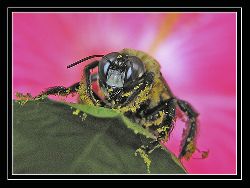

Label of image: 1 (bees). Original size: (500, 333)


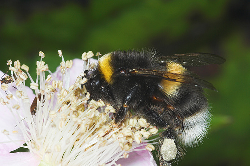

Label of image: 0 (ants). Original size: (500, 376)


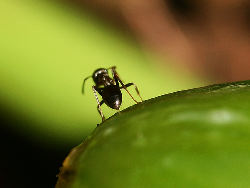

In [14]:
print('ImageNet classes:', *imagenet_dataset.classes)
# Show a random image and the corresponding target.
for i in range(3):
  img, target = random.choice(imagenet_dataset)
  print('Label of image: %d (%s). Original size: %s' % (target, imagenet_dataset.classes[target], img.size))
  # Reduce image size by half to fit into the page :)
  display.display(img.resize((img.size[0] // 2, img.size[1] // 2)))

A coomon tecnnique to handle this is to take some segment of the image and resize it to have an image of fixed squre size.

For training the segment selection is usually randomized.
For evalution a "center" crop is used.

Actual image:


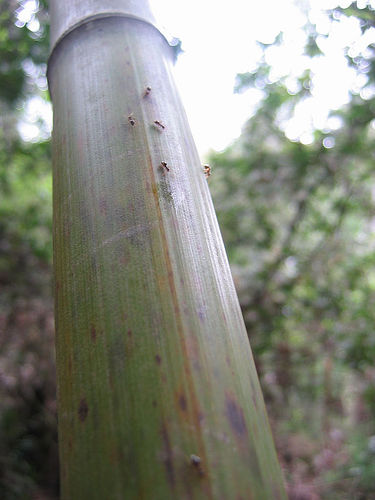

Input to the net for training


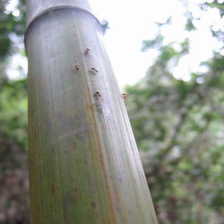

Input to the net for eval


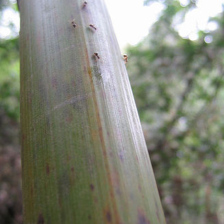

In [15]:
img, _ = random.choice(imagenet_dataset)
print('Actual image:')
display.display(img)
print('Input to the net for training')
display.display(transforms.RandomResizedCrop(224)(img))
print('Input to the net for eval')
display.display(transforms.CenterCrop(224)(transforms.Resize(256)(img)))

If a pre-trained model is used, it's important to match the transformation.

In [16]:
# This is the default transform used in ImageNet models.
inference_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# For visualization purposes we'll create a separate transform that operates in image space.
inference_transform_show = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

# Reload out dataset with this transform.
trasformed_imagenet_dataset = datasets.ImageFolder(
    '/tmp/imagenet/unpacked/hymenoptera_data/val',
    transform=inference_transform,
)

trasformed_imagenet_loader = torch.utils.data.DataLoader(trasformed_imagenet_dataset, batch_size=16, shuffle=False)

# Load a pretrained model.
imagenet_resnet = torchvision.models.resnet18(pretrained=True)

# The loaded model is trained to classify image across 1000 classes. We have only two classes so have to take the two correpsonding lines from the softmax.
ANT_CLASS_ID = 310
BEE_CLASS_ID = 309
imagenet_resnet.fc.weight.data = imagenet_resnet.fc.weight.data[[ANT_CLASS_ID, BEE_CLASS_ID]]
imagenet_resnet.fc.bias.data = imagenet_resnet.fc.bias.data[[ANT_CLASS_ID, BEE_CLASS_ID]]

# Check the model accuracy.
test(imagenet_resnet.cuda(), trasformed_imagenet_loader)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth


0it [00:00, ?it/s]

3637248it [00:00, 36341582.36it/s]

12451840it [00:00, 44118576.71it/s]

22355968it [00:00, 52920005.51it/s]

31178752it [00:00, 60130880.59it/s]

39682048it [00:00, 65901001.61it/s]

46827520it [00:00, 80116160.93it/s]

Accuracy: 147/153 (96%)


96.07843137254902

The model quality is pretty high, but there are a few mistakes. Explore misclassified images below. Why do you think the network made a mistake?


Img id=6. Excpected class ants, but predicted class bees.


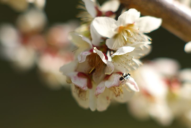

Img id=41. Excpected class ants, but predicted class bees.


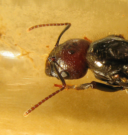

Img id=81. Excpected class bees, but predicted class ants.


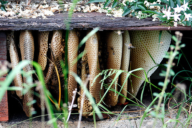

Img id=114. Excpected class bees, but predicted class ants.


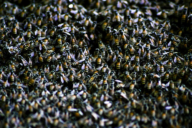

Img id=144. Excpected class bees, but predicted class ants.


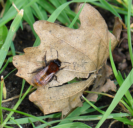

Img id=150. Excpected class bees, but predicted class ants.


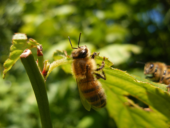

In [17]:
for i in range(len(trasformed_imagenet_dataset)):
  img, _ = imagenet_dataset[i]
  tensor, target = trasformed_imagenet_dataset[i]
    
  logits = imagenet_resnet(tensor.unsqueeze(0).cuda()).squeeze(0).cpu()
  _, prediction = logits.max(-1)
  if prediction != target:
    print('Img id=%d. Excpected class %s, but predicted class %s.' % (
        i,
        imagenet_dataset.classes[target],
        imagenet_dataset.classes[prediction]))
    display_thumb(img)
  

As you saw the random crop not always catches the object. Lets understand how does it affect the classification.

**Task** . For a random image from `imagenet_dataset` sample a few random crops and find the most _bee-like_ and the most _ant-like_ ones. How do they look like? (Hint: take a look at the previous section)

Most ant-like


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


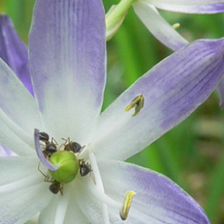

Most bee-like


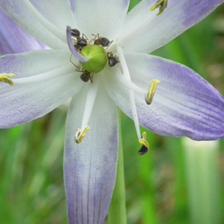

In [18]:
random_id = 40
img, _ = imagenet_dataset[random_id]

random_crops = [transforms.RandomResizedCrop(224)(img)
                for _ in range(10)]
def beeness(image):
  # Conver image to tensor and apply default for the dataset mean-variance normalization.
  image = transforms.ToTensor()(image)
  image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(image)
  ###########################################################################
  # TODO: Sort the random_crops by probability of bee-ness.                 #
  # You need to compute logits and convert them to probabilities.           #
  # Put your code between START_GRADING and END_GRADING.                    #
  ###########################################################################
  # ~~START_GRADING~~
  logits = imagenet_resnet(image.unsqueeze(0).cuda()).squeeze(0).cpu()
  probs= nn.functional.softmax(logits)
  # ~~END_GRADING~~ 
  return probs[0].item()
  
random_crops = sorted(random_crops, key=beeness)

print('Most ant-like'); display.display(random_crops[0])
print('Most bee-like'); display.display(random_crops[-1])